In [1]:
import findspark
findspark.init()

In [2]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder
from pyspark.ml.regression import LinearRegression, DecisionTreeRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.regression import LinearRegressionModel, DecisionTreeRegressionModel
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

In [3]:
spark = SparkSession.builder.appName('Gemstone').getOrCreate()

# <font color='Mediumblue'>Table Contents</font> </br>

<details>
    <summary>Click for details</summary>


1. [Overview about data](#overview) <br/> <br />

2. [Pre-process data](#pre-process) <br /> <br />

    2.1. [Handle Null and NaN values](#NullNaN)
 
     > *[fillNaN func](#func1) 
           
    2.2. [Handle Special values](#zeros)
    
    2.3. [Handle outlier with Robust Scaling](#outliers)
    
     > *[Robust scaling func](#func2)
            
    2.4. [Final data](#data)
<br>

3. [Building model](#model)

    3.1. [Split data](#split)
    
    3.2. [Linear regression](#linear)
    
    3.3. [Decision Tree regressor](#tree)

<br> 

4. [Prediction with new data](#predict)

    4.1 [New data](#new)
    
    4.2 [Process new data](#modeled)
    
    4.3 [Prediction and result](#result)
    
    > *[Result](#table)
    
</details>

## <a name="overview">Overview about data</a>

In [4]:
data = spark.read.csv("Gemstone/cubic_zirconia.csv", inferSchema = True, header = True)

In [5]:
data.printSchema()

root
 |-- _c0: integer (nullable = true)
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- price: integer (nullable = true)



In [6]:
data.count()

26967

In [7]:
# drop the _c0
data = data.drop("_c0")
data.printSchema()

root
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = true)
 |-- table: double (nullable = true)
 |-- x: double (nullable = true)
 |-- y: double (nullable = true)
 |-- z: double (nullable = true)
 |-- price: integer (nullable = true)



In [8]:
data.show(3)

+-----+---------+-----+-------+-----+-----+----+----+----+-----+
|carat|      cut|color|clarity|depth|table|   x|   y|   z|price|
+-----+---------+-----+-------+-----+-----+----+----+----+-----+
|  0.3|    Ideal|    E|    SI1| 62.1| 58.0|4.27|4.29|2.66|  499|
| 0.33|  Premium|    G|     IF| 60.8| 58.0|4.42|4.46| 2.7|  984|
|  0.9|Very Good|    E|   VVS2| 62.2| 60.0|6.04|6.12|3.78| 6289|
+-----+---------+-----+-------+-----+-----+----+----+----+-----+
only showing top 3 rows



## <a name="pre-process">Pre-process data</a>

### <a name="NullNaN">Handle Null and NaN values</a>

In [9]:
data.select([count(when(col(c).isNull(), c)).alias(c) for c in data.columns]).show()

+-----+---+-----+-------+-----+-----+---+---+---+-----+
|carat|cut|color|clarity|depth|table|  x|  y|  z|price|
+-----+---+-----+-------+-----+-----+---+---+---+-----+
|    0|  0|    0|      0|  697|    0|  0|  0|  0|    0|
+-----+---+-----+-------+-----+-----+---+---+---+-----+



<li><b>Has null value in depth columns</li></b>

In [10]:
data.select([count(when(isnan(col(c)), c)).alias(c) for c in data.columns]).show()

+-----+---+-----+-------+-----+-----+---+---+---+-----+
|carat|cut|color|clarity|depth|table|  x|  y|  z|price|
+-----+---+-----+-------+-----+-----+---+---+---+-----+
|    0|  0|    0|      0|    0|    0|  0|  0|  0|    0|
+-----+---+-----+-------+-----+-----+---+---+---+-----+



<li><b>Has no NaN values</li></b>

#### Take a look at the null values

In [11]:
data.filter(data.depth.isNull()).show()

+-----+---------+-----+-------+-----+-----+----+----+----+-----+
|carat|      cut|color|clarity|depth|table|   x|   y|   z|price|
+-----+---------+-----+-------+-----+-----+----+----+----+-----+
| 0.34|    Ideal|    D|    SI1| NULL| 57.0| 4.5|4.44|2.74|  803|
| 0.74|    Ideal|    E|    SI2| NULL| 59.0|5.92|5.97|3.52| 2501|
|  1.0|  Premium|    F|    SI1| NULL| 59.0| 6.4|6.36| 4.0| 5292|
| 1.11|  Premium|    E|    SI2| NULL| 61.0|6.66|6.61|4.09| 4177|
|  1.0|Very Good|    F|    VS2| NULL| 55.0|6.39|6.44|3.99| 6340|
| 0.43|    Ideal|    E|    SI1| NULL| 56.0|4.82|4.79|3.01|  975|
| 0.41|    Ideal|    I|     IF| NULL| 57.0|4.78|4.81|2.93|  953|
| 0.71|  Premium|    F|    VS1| NULL| 58.0|5.71|5.67|3.57| 2879|
| 0.51|Very Good|    E|    VS1| NULL| 54.7|5.12|5.15|31.8| 1970|
| 0.29|Very Good|    I|    VS2| NULL| 55.0|4.25|4.27|2.66|  384|
|  0.9|    Ideal|    G|    SI2| NULL| 56.0|6.14|6.19|3.85| 3500|
| 0.71|Very Good|    H|    SI1| NULL| 57.0|5.65|5.61|3.55| 2207|
|  1.1|Very Good|    F|  

#### <a name="func1">Impute function</a>

In [12]:
def fillna_mean(data, include=set()): 
    means = data.agg(*(
        mean(x).alias(x) for x in data.columns if x in include
    ))
    return data.fillna(means.first().asDict())

In [13]:
data = fillna_mean(data, ['depth'])

In [14]:
data.filter(data.depth.isNull()).show()

+-----+---+-----+-------+-----+-----+---+---+---+-----+
|carat|cut|color|clarity|depth|table|  x|  y|  z|price|
+-----+---+-----+-------+-----+-----+---+---+---+-----+
+-----+---+-----+-------+-----+-----+---+---+---+-----+



### <a name="NullNaN">Handle Special values</a>

<i> x, y, z is the information about the length, width, height of the gems, so if the gems exists those values must bigger than 0 -> check the zero values </i>

In [15]:
data.filter(((data.x == 0) | (data.y == 0) | (data.z == 0))).show()

+-----+-------+-----+-------+-----+-----+----+----+---+-----+
|carat|    cut|color|clarity|depth|table|   x|   y|  z|price|
+-----+-------+-----+-------+-----+-----+----+----+---+-----+
| 0.71|   Good|    F|    SI2| 64.1| 60.0| 0.0| 0.0|0.0| 2130|
| 2.02|Premium|    H|    VS2| 62.7| 53.0|8.02|7.95|0.0|18207|
| 0.71|   Good|    F|    SI2| 64.1| 60.0| 0.0| 0.0|0.0| 2130|
|  2.2|Premium|    H|    SI1| 61.2| 59.0|8.42|8.37|0.0|17265|
| 2.18|Premium|    H|    SI2| 59.4| 61.0|8.49|8.45|0.0|12631|
|  1.1|Premium|    G|    SI2| 63.0| 59.0| 6.5|6.47|0.0| 3696|
| 1.14|   Fair|    G|    VS1| 57.5| 67.0| 0.0| 0.0|0.0| 6381|
| 1.01|Premium|    H|     I1| 58.1| 59.0|6.66| 6.6|0.0| 3167|
| 1.12|Premium|    G|     I1| 60.4| 59.0|6.71|6.67|0.0| 2383|
+-----+-------+-----+-------+-----+-----+----+----+---+-----+



#### Impute the zeros value (0 -> Null -> mean)

In [16]:
data = data.replace(0, None, ['x', 'y', 'z'])

In [17]:
data.filter(((data.x.isNull()) | (data.y.isNull()) | (data.z.isNull()))).show()

+-----+-------+-----+-------+-----+-----+----+----+----+-----+
|carat|    cut|color|clarity|depth|table|   x|   y|   z|price|
+-----+-------+-----+-------+-----+-----+----+----+----+-----+
| 0.71|   Good|    F|    SI2| 64.1| 60.0|NULL|NULL|NULL| 2130|
| 2.02|Premium|    H|    VS2| 62.7| 53.0|8.02|7.95|NULL|18207|
| 0.71|   Good|    F|    SI2| 64.1| 60.0|NULL|NULL|NULL| 2130|
|  2.2|Premium|    H|    SI1| 61.2| 59.0|8.42|8.37|NULL|17265|
| 2.18|Premium|    H|    SI2| 59.4| 61.0|8.49|8.45|NULL|12631|
|  1.1|Premium|    G|    SI2| 63.0| 59.0| 6.5|6.47|NULL| 3696|
| 1.14|   Fair|    G|    VS1| 57.5| 67.0|NULL|NULL|NULL| 6381|
| 1.01|Premium|    H|     I1| 58.1| 59.0|6.66| 6.6|NULL| 3167|
| 1.12|Premium|    G|     I1| 60.4| 59.0|6.71|6.67|NULL| 2383|
+-----+-------+-----+-------+-----+-----+----+----+----+-----+



In [18]:
data = fillna_mean(data, ['x', 'y', 'z'])

In [19]:
# Check again
data.filter(((data.x.isNull()) | (data.y.isNull()) | (data.z.isNull()))).show()

+-----+---+-----+-------+-----+-----+---+---+---+-----+
|carat|cut|color|clarity|depth|table|  x|  y|  z|price|
+-----+---+-----+-------+-----+-----+---+---+---+-----+
+-----+---+-----+-------+-----+-----+---+---+---+-----+



### Check and drop duplicate

In [20]:
data = data.dropDuplicates()

### <a name="outliers">Handle outlier with Robust Scaling</a>

In [21]:
temp = data.select(['carat','depth','table','x','y','z']).toPandas()

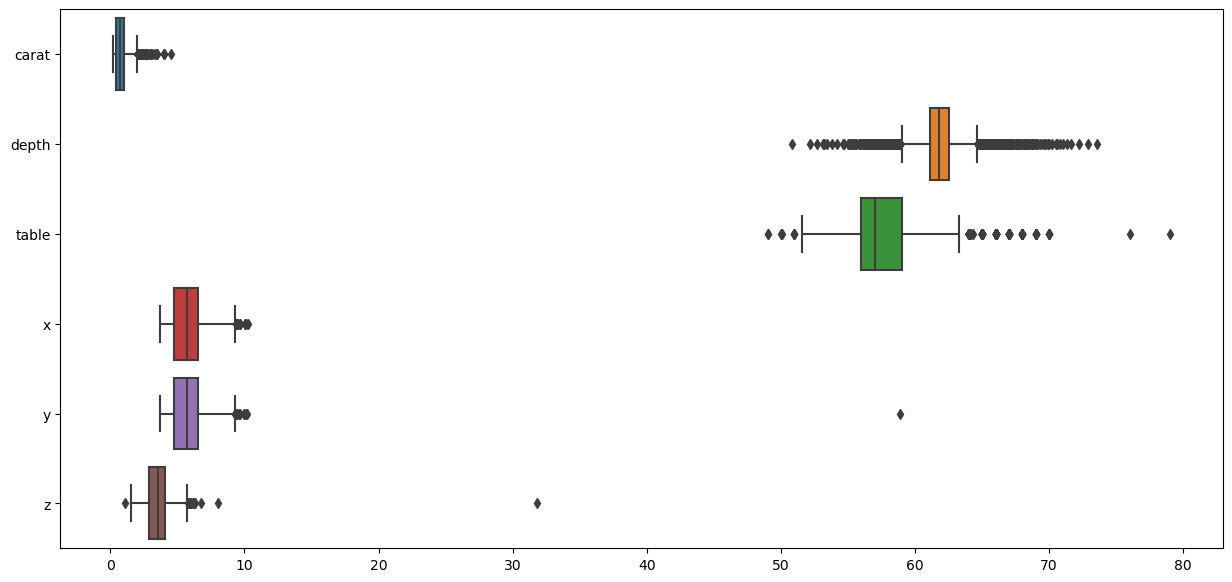

In [22]:
plt.figure(figsize=(15, 7))
sns.boxplot(data = temp, orient='h')
plt.show()

<b>Too much outliers -> scale data</b>

#### <a name="func2">Robust Scaling function</a>

In [23]:
def iqr_outlier_treatment(dataframe, columns, factor=1.5):
    """
    Detects and treats outliers using IQR for multiple variables in a PySpark DataFrame.

    :param dataframe: The input PySpark DataFrame
    :param columns: A list of columns to apply IQR outlier treatment
    :param factor: The IQR factor to use for detecting outliers (default is 1.5)
    :return: The processed DataFrame with outliers treated
    """
    for column in columns:
        # Calculate Q1, Q3, and IQR
        quantiles = dataframe.approxQuantile(column, [0.25, 0.75], 0.01)
        q1, q3 = quantiles[0], quantiles[1]
        iqr = q3 - q1

        # Define the upper and lower bounds for outliers
        lower_bound = q1 - factor * iqr
        upper_bound = q3 + factor * iqr
        
        print("Lower bound of " + column, lower_bound)
        print("Upper bound of " + column, upper_bound)
        print("\n")

        # Filter outliers and update the DataFrame
        dataframe = dataframe.withColumn(column, 
                                         when(col(column) < lower_bound, lower_bound)
                                        .when(col(column) > upper_bound, upper_bound)
                                        .otherwise(col(column)))

    return dataframe

In [24]:
scale_list = ['carat','depth','table','x','y','z']
scaled_data = iqr_outlier_treatment(data, scale_list, factor = 1.5)

Lower bound of carat -0.5599999999999999
Upper bound of carat 2.0


Lower bound of depth 59.0
Upper bound of depth 64.6


Lower bound of table 51.5
Upper bound of table 63.5


Lower bound of x 1.955
Upper bound of x 9.275


Lower bound of y 1.9950000000000006
Upper bound of y 9.235


Lower bound of z 1.2049999999999994
Upper bound of z 5.7250000000000005




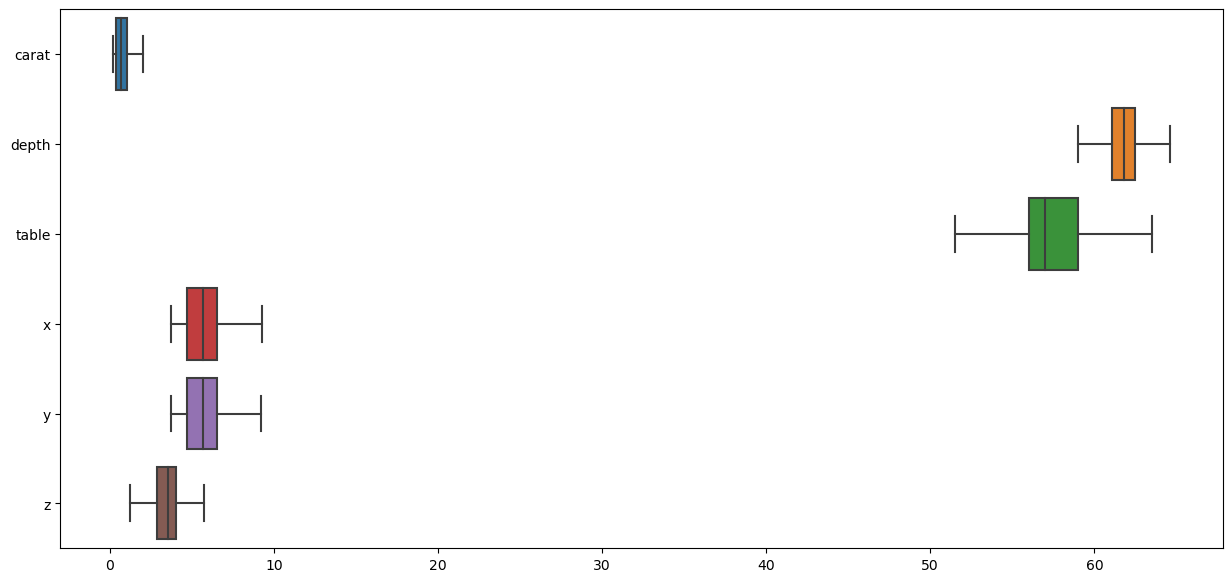

In [25]:
temp2 = scaled_data.select(['carat','depth','table','x','y','z']).toPandas()
plt.figure(figsize=(15, 7))
sns.boxplot(data = temp2, orient = 'h')
plt.show()

<li><b> Check again the number of data </b></li>

In [26]:
print("Before the robust: ", data.count(), " elements")
print("After the robust: ", scaled_data.count(), " elements")

Before the robust:  26933  elements
After the robust:  26933  elements


In [27]:
scaled_data.printSchema()

root
 |-- carat: double (nullable = true)
 |-- cut: string (nullable = true)
 |-- color: string (nullable = true)
 |-- clarity: string (nullable = true)
 |-- depth: double (nullable = false)
 |-- table: double (nullable = true)
 |-- x: double (nullable = false)
 |-- y: double (nullable = false)
 |-- z: double (nullable = false)
 |-- price: integer (nullable = true)



### Reduce category values

<ul>Reduce the color column:
    <li> Change the J -> best </li>
    <li> Change the I, H -> vgood </li>
    <li> Change the G, F -> good </li>
    <li> Change the E -> bad </li>
    <li> Change the D -> worst </li>
</ul>

In [28]:
scaled_data = scaled_data.withColumn('color',
                                     when(col('color') == "J", "best")
                                     .when(((col('color') == "I") | (col('color') == "H")), "vgood")
                                     .when(((col('color') == "G") | (col('color') == "F")), "good")
                                     .when(col('color') == "E", "bad")
                                     .otherwise("worst"))

<ul> Reduce the Clarity columns:
    <li> Change the I1, I2, I3 -> best </li>
    <li> Change the SI1, SI2 -> vgood </li>
    <li> Change the VS1, VS2 -> good </li>
    <li> Change the VVS1, VVS2 -> bad </li>
    <li> Change the IF -> worst </li>
</ul>

In [29]:
scaled_data = scaled_data.withColumn('clarity',
                                     when(col('clarity') == "IF", "worst")
                                     .when(((col('clarity') == "SI1") | (col('clarity') == "SI2")), "vgood")
                                     .when(((col('clarity') == "VS1") | (col('clarity') == "VS2")), "good")
                                     .when(((col('clarity') == "VVS1") | (col('clarity') == "VVS2")), "bad")
                                     .otherwise("best"))

In [30]:
scaled_data.select(['color', 'clarity']).distinct().show(3)

+-----+-------+
|color|clarity|
+-----+-------+
|  bad|  vgood|
| good|   best|
|vgood|  worst|
+-----+-------+
only showing top 3 rows



### Convert string data

In [31]:
indexer1 = StringIndexer(inputCol = 'cut', outputCol = 'cut_index')
indexer2 = StringIndexer(inputCol = 'color', outputCol = 'color_index')
indexer3 = StringIndexer(inputCol = 'clarity', outputCol = 'clarity_index')

encoder = OneHotEncoder(inputCols = ['clarity_index'],
                        outputCols = ['clarity_en'])

pipeline = Pipeline(stages = [indexer1, indexer2, indexer3, encoder])
indexer_data = pipeline.fit(scaled_data).transform(scaled_data)

In [32]:
indexer_data.show(3)

+-----+---------+-----+-------+-----+-----+----+----+----+-----+---------+-----------+-------------+-------------+
|carat|      cut|color|clarity|depth|table|   x|   y|   z|price|cut_index|color_index|clarity_index|   clarity_en|
+-----+---------+-----+-------+-----+-----+----+----+----+-----+---------+-----------+-------------+-------------+
| 0.52|    Ideal|  bad|   good| 61.5| 56.0|5.18| 5.2|3.19| 1576|      0.0|        2.0|          1.0|(4,[1],[1.0])|
| 1.01|Very Good| good|    bad| 61.8| 59.0|6.47|6.41|3.98| 8373|      2.0|        0.0|          2.0|(4,[2],[1.0])|
| 0.35|    Ideal| good|    bad| 62.1| 56.0|4.52|4.56|2.82|  745|      0.0|        0.0|          2.0|(4,[2],[1.0])|
+-----+---------+-----+-------+-----+-----+----+----+----+-----+---------+-----------+-------------+-------------+
only showing top 3 rows



### <a name="data">Final data</a>

In [33]:
final_data = indexer_data.select(['carat', 'depth', 'table',
                                 'x', 'y', 'z',
                                 'cut_index', 'color_index', 'clarity_en', 
                                 'price'])
final_data.show(5)

+-----+-----+-----+----+----+----+---------+-----------+-------------+-----+
|carat|depth|table|   x|   y|   z|cut_index|color_index|   clarity_en|price|
+-----+-----+-----+----+----+----+---------+-----------+-------------+-----+
| 0.52| 61.5| 56.0|5.18| 5.2|3.19|      0.0|        2.0|(4,[1],[1.0])| 1576|
| 1.01| 61.8| 59.0|6.47|6.41|3.98|      2.0|        0.0|(4,[2],[1.0])| 8373|
| 0.35| 62.1| 56.0|4.52|4.56|2.82|      0.0|        0.0|(4,[2],[1.0])|  745|
| 0.32| 62.3| 58.0|4.41|4.36|2.73|      1.0|        0.0|(4,[1],[1.0])|  720|
| 0.52| 62.5| 59.0|5.14|5.16|3.22|      2.0|        4.0|(4,[0],[1.0])| 1019|
+-----+-----+-----+----+----+----+---------+-----------+-------------+-----+
only showing top 5 rows



In [34]:
assembler = VectorAssembler(inputCols = ['carat', 'depth', 'table',
                                         'x', 'y', 'z',
                                         'cut_index', 'color_index', 'clarity_en'], 
                            outputCol = 'features')
final_data = assembler.transform(final_data)

## <a name="Model">Building model</a>

### <a name="split">Split data</a>

In [35]:
data = final_data.select(['features', 'price'])
train_data, test_data = data.randomSplit([0.7, 0.3], seed = 42)

In [36]:
train_data.describe().show()

+-------+------------------+
|summary|             price|
+-------+------------------+
|  count|             18908|
|   mean| 3911.875555320499|
| stddev|4026.2567132999984|
|    min|               326|
|    max|             18804|
+-------+------------------+



In [37]:
test_data.describe().show()

+-------+-----------------+
|summary|            price|
+-------+-----------------+
|  count|             8025|
|   mean|3997.962367601246|
| stddev|4013.411572028205|
|    min|              326|
|    max|            18818|
+-------+-----------------+



### <a name="linear">Linear regression</a>

In [38]:
lr = LinearRegression(featuresCol = "features",
                      labelCol = "price",
                      predictionCol = "Predict price")
lrModel = lr.fit(train_data)

In [39]:
print("Coefficients: {}\nIntercept: {}".format(lrModel.coefficients, lrModel.intercept))

Coefficients: [13531.944291293277,11.802211830781278,-34.81984413690858,-2283.073240849306,1729.7831969645397,-2378.8835907435578,-123.825605593274,-86.97586996335065,2888.126907995116,3825.2557913782916,4364.786914842242,4554.492460580685]
Intercept: 2803.5689897096568


In [40]:
test_result = lrModel.evaluate(test_data)
test_result.residuals.show(3)

+------------------+
|         residuals|
+------------------+
|2466.6020516502044|
|1085.4020643777399|
|1110.6256491254621|
+------------------+
only showing top 3 rows



In [41]:
print("RMSE: {}\nr2: {}".format(test_result.rootMeanSquaredError, test_result.r2))

RMSE: 1254.5298514114738
r2: 0.9022788152810179


<b>The r2 is 0.90 -> maybe this is a good model for this data</b>

In [42]:
test_model = lrModel.transform(test_data)
test_model.select("price", "Predict price").show(10)

+-----+------------------+
|price|     Predict price|
+-----+------------------+
| 1928|-538.6020516502044|
| 3377|  2291.59793562226|
| 3382| 2271.374350874538|
| 3444|  2505.72510822481|
| 3544| 2716.576260218361|
| 3609|2596.1905670839446|
| 3168|2735.6699663990753|
| 3824| 3389.724816231645|
| 4643| 5434.246538353715|
| 6175|  6856.77113454585|
+-----+------------------+
only showing top 10 rows



<i><b>The prediction seems ok however the price 1928 is predict in negative number. Hope that the next model is better. </i></b>

### <a name="tree">Decision Tree regressor</a>

In [43]:
dct = DecisionTreeRegressor(featuresCol = "features", 
                            labelCol = 'price', 
                            predictionCol = 'Predict price',
                            seed = 35, maxDepth = 30)
dctModel = dct.fit(train_data)

In [44]:
dtevaluator = RegressionEvaluator(predictionCol = "Predict price", 
                                  labelCol = "price", 
                                  metricName = "r2")

In [45]:
dct_test_model = dctModel.transform(test_data)
dct_test_model.select("price", "Predict price").show(10)

+-----+-------------+
|price|Predict price|
+-----+-------------+
| 1928|       1273.0|
| 3377|       3444.0|
| 3382|       3444.0|
| 3444|       3507.0|
| 3544|       3547.0|
| 3609|       3547.0|
| 3168|       3607.0|
| 3824|       3607.0|
| 4643|       6028.0|
| 6175|       5808.0|
+-----+-------------+
only showing top 10 rows



In [46]:
dtevaluator.evaluate(dct_test_model)

0.9354699926475724

<b> After trying some max depth i see that the max r2 is about 0.935 and it is a little bit bigger than the regular Linear Regression and all the predict value are positive -> which are more logical than the linear regression.</b>

<b> With that i choose the DCTree to predict with the new data </b>

## <a name="predict">Prediction with new data</a>

###  <a name="new">New data</a>
| carat | cut  | color | clarity | depth | table | x   | y   | z   |
|-------|------|-------|---------|-------|-------|-----|-----|-----|
| 1.45  | Fair | G     | VS2     | 65.2  | 54    | 7.2 | 7.1 | 4.6 |

### <a name="modeled">Process new data</a>
| carat | cut | color | clarity       | depth | table | x   | y   | z   |
|-------|-----|-------|---------------|-------|-------|-----|-----|-----|
| 1.45  | 4   | 2     | (4,[1],[1.0]) | 64.6  | 54    | 7.2 | 7.1 | 4.6 |

In [47]:
new_data = spark.createDataFrame([
    Row(carat = 1.45, cut = 4, color = 2, clarity = Vectors.sparse(4, [1], [1.0]),
        depth = 64.6, table = 54, x = 7.2, y = 7.1, z = 4.6)])
new_data.show()

+-----+---+-----+-------------+-----+-----+---+---+---+
|carat|cut|color|      clarity|depth|table|  x|  y|  z|
+-----+---+-----+-------------+-----+-----+---+---+---+
| 1.45|  4|    2|(4,[1],[1.0])| 64.6|   54|7.2|7.1|4.6|
+-----+---+-----+-------------+-----+-----+---+---+---+



### <a name="result">Prediction and result</a>

In [48]:
assembler2 = VectorAssembler(inputCols = ['carat', 'depth', 'table',
                                         'x', 'y', 'z',
                                         'cut', 'color', 'clarity'], 
                            outputCol = 'features')
feature = assembler2.transform(new_data)
feature.show()

+-----+---+-----+-------------+-----+-----+---+---+---+--------------------+
|carat|cut|color|      clarity|depth|table|  x|  y|  z|            features|
+-----+---+-----+-------------+-----+-----+---+---+---+--------------------+
| 1.45|  4|    2|(4,[1],[1.0])| 64.6|   54|7.2|7.1|4.6|[1.45,64.6,54.0,7...|
+-----+---+-----+-------------+-----+-----+---+---+---+--------------------+



In [49]:
new_data = feature.select('features')
dctModel.transform(new_data).show()

+--------------------+-------------+
|            features|Predict price|
+--------------------+-------------+
|[1.45,64.6,54.0,7...|      12606.0|
+--------------------+-------------+



####  <a name="table">Result</a>
| carat | cut  | color | clarity | depth | table | x   | y   | z   | price |
|-------|------|-------|---------|-------|-------|-----|-----|-----|-------|
| 1.45  | Fair | G     | VS2     | 65.2  | 54    | 7.2 | 7.1 | 4.6 | 12606 |